Vamos a listar las "jotas", es decir, el índice de las coordenadas totales, siguiendo este orden: de la esquina inferior [1,1], ese será j=1, luego j=2 corresponderá a [1,2], j=64 será [1,64] y luego j=65 será [2,1]. Recuerda que esto está ordenado como MATRICES, entonces j=5, [1,5]  es el lugar coordenada x=5 y y=1. Respeta el orden y todo saldrá bien.

In [1]:
ConjuntoDeCoordenadasTotal=Array[]

0-element Array{Array{T,N},1}

In [2]:
for j=1:64,k=1:64
    push!(ConjuntoDeCoordenadasTotal,[j,k])
end
ConjuntoDeCoordenadasTotal[65]

2-element Array{Int64,1}:
 2
 1

Por cierto, estoy SEGURO que esta NO es la forma más inteligente de hacerlo, pero funciona. Ya después optimizamos.

In [3]:
ConjuntoDeCoordenadasTotal[65]

2-element Array{Int64,1}:
 2
 1

In [4]:
BceroDura=readdlm("BceroDura.dat");

In [5]:
xk=ConjuntoDeCoordenadasTotal[70]

2-element Array{Int64,1}:
 2
 6

In [6]:
BceroDura[64,64]=137.089 #Correccion por convergencia, hay que checar el notebook anterior y ver porque pasa eso...

137.089

In [17]:
xk=ConjuntoDeCoordenadasTotal[70]
BceroDura[xk...], BceroDura[2,6]


(7.700687690958998,7.700687690958998)

Esta parte de abajo debe ser trivialmente paralelizable, ¿no?

In [50]:
jmax=128
xconstante=[64,64]
Kduras=zeros(jmax,jmax);
@time for j=1:jmax
     xj=ConjuntoDeCoordenadasTotal[j]
     for k=1:jmax
            xk=ConjuntoDeCoordenadasTotal[k+750]
        for l=1:jmax
            xl=ConjuntoDeCoordenadasTotal[l]
            Kduras[j,k]+=BceroDura[(xk-xl+xconstante)...]*BceroDura[(xj-xl+xconstante)...]
            end
    end
end

  7.517040 seconds (50.38 M allocations: 1.782 GB, 2.98% gc time)


In [46]:
using PyPlot

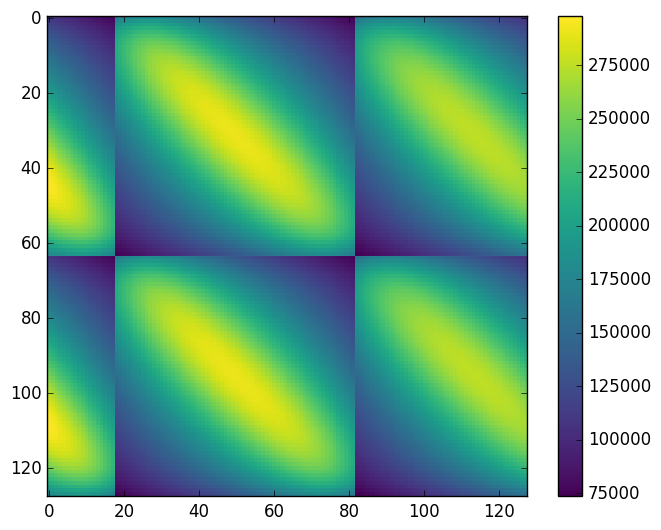

PyObject <matplotlib.colorbar.Colorbar object at 0x7f322aca5cc0>

In [51]:
figuru=imshow(Kduras, origin="upper",interpolation="nearest",cmap="viridis") 
cb=colorbar(figuru)

Hay algo raro... me está saliendo Ciclica la integral... ¿tiene sentido?

In [44]:
Kduras[1:64,1:64]-Kduras[65:128,65:128]

64x64 Array{Float64,2}:
 2388.34   2538.0    2653.55   …  120.672     118.549     116.501   
 2538.0    2708.31   2843.15      133.034     130.683     128.414   
 2653.55   2843.15   2997.08      144.177     141.617     139.148   
 2730.9    2936.84   3107.93      153.409     150.675     148.038   
 2762.45   2980.63   3165.1       159.36      156.512     153.766   
 2733.97   2959.05   3151.41   …  159.4       156.551     153.803   
 2618.2    2847.91   3047.4       154.315     151.548     148.88    
 2448.73   2679.49   2883.6       146.254     143.62      141.081   
 2246.96   2474.37   2679.49      136.311     133.843     131.464   
 2028.0    2246.96   2448.73      124.99      122.714     120.52    
 1804.2    2009.11   2202.57   …  112.585     110.522     108.534   
 1586.42   1771.52   1951.32       99.3486     97.5166     95.7518  
 1381.54   1543.72   1704.3        85.3884     83.8033     82.2768  
    ⋮                          ⋱                                    
  143.941 

In [28]:
extrema(Kduras)

(30066.874930392416,88922.76676493007)